# STA9131 Assignment 2-1: Linear Classifiers

Before we start, please put your name, ID number, option (and your group members', if any) in following format: e.g., <br>
```
name = 'Kibok Lee'
idnum = '2022123456'
option = '1'
group = {
    '2022123457': 'Alice Ahn',
    '2022123458': 'Bob Bae',
    '2022123459': 'Carol Choi',
}
```

In [2]:
# TODO: Put your name, id number, option (and your group members', if any):
# option 1 : You did your assignment yourself.
# option 2 : You didn't do your assignment yourself,
#            but you added your own comment to show your understanding.
# option 2L: You referred to LLMs, e.g., ChatGPT,
#            but you added your own comment to show your understanding,
#            and you submit a report (in pdf) with all your queries & outputs.
name = 'Soyoung Park'
idnum = '2024311159'
option = '1'
group = {}

# Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [3]:
%load_ext autoreload
%autoreload 2

## Google Colab Setup
Next, we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine, you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly, then running the following cell should print the filenames from the assignment:

```
['a2_helpers.py', 'common', 'linear_classifier.ipynb', 'linear_classifier.py', 'two_layer_net.ipynb', 'two_layer_net.py']
```

In [5]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment.
# Example: If you create a STA9131 folder and put all the files under A2 folder, then 'STA9131/A2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'STA9131/A2'

GOOGLE_DRIVE_PATH = os.path.join('/content/drive/MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(sorted(os.listdir(GOOGLE_DRIVE_PATH)))

['__pycache__', 'a2_helpers.py', 'common', 'linear_classifier.ipynb', 'linear_classifier.py', 'softmax_best_model.pt', 'svm_best_model.pt', 'two_layer_net.ipynb', 'two_layer_net.py']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from common!
Hello from linear_classifier.py!
```

as well as the last edit time for the file `linear_classifier.py`.

In [6]:
import os
import sys
import time

sys.path.insert(0, GOOGLE_DRIVE_PATH)

os.environ["TZ"] = "Asia/Seoul"
time.tzset()

from common import hello as hello_common
hello_common()

from linear_classifier import hello as hello_linear_classifier
hello_linear_classifier()

linear_classifier_path = os.path.join(GOOGLE_DRIVE_PATH, 'linear_classifier.py')
linear_classifier_edit_time = time.ctime(os.path.getmtime(linear_classifier_path))
print('linear_classifier.py last edited on %s' % linear_classifier_edit_time)

Hello from common!
Hello from linear_classifier.py!
linear_classifier.py last edited on Thu Mar 20 15:28:10 2025


## Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [7]:
import os
import common
from common import reset_seed
import torch
import matplotlib.pyplot as plt
import time
import math
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

We will use a GPU to accelerate our computation. Run the following cell to make sure you are using a GPU.

In [8]:
if torch.cuda.is_available():
    print('Good to go! You are using', torch.cuda.get_device_name())
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go! You are using NVIDIA A100-SXM4-40GB


## Load CIFAR-10
We will first load the CIFAR-10 dataset. The utility function `common.data.preprocess_cifar10()` returns the entire CIFAR-10 dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

In this notebook, we will use the **bias trick**: By adding an extra constant feature of ones to each image, we avoid the need to keep track of a bias vector; the bias will be encoded as the part of the weight matrix that interacts with the constant ones in the input.

You can learn more about the `common.data.preprocess_cifar10` function by invoking the `help` command:

In [8]:
help(common.data.preprocess_cifar10)

Help on function preprocess_cifar10 in module common.data:

preprocess_cifar10(cuda=True, show_examples=True, bias_trick=False, flatten=True, validation_ratio=0.2, dtype=torch.float32)
    Returns a preprocessed version of the CIFAR10 dataset, automatically
    downloading if necessary. We perform the following steps:
    
    (0) [Optional] Visualize some images from the dataset
    (1) Normalize the data by subtracting the mean
    (2) Reshape each image of shape (3, 32, 32) into a vector of shape (3072,)
    (3) [Optional] Bias trick: add an extra dimension of ones to the data
    (4) Carve out a validation set from the training set
    
    Inputs:
    - cuda: If true, move the entire dataset to the GPU
    - validation_ratio: Float in the range (0, 1) giving the fraction of the
      train set to reserve for validation
    - bias_trick: Boolean telling whether or not to apply the bias trick
    - show_examples: Boolean telling whether or not to visualize data samples
    - dtype: 

We can now run the `common.data.preprocess` function to get our data:

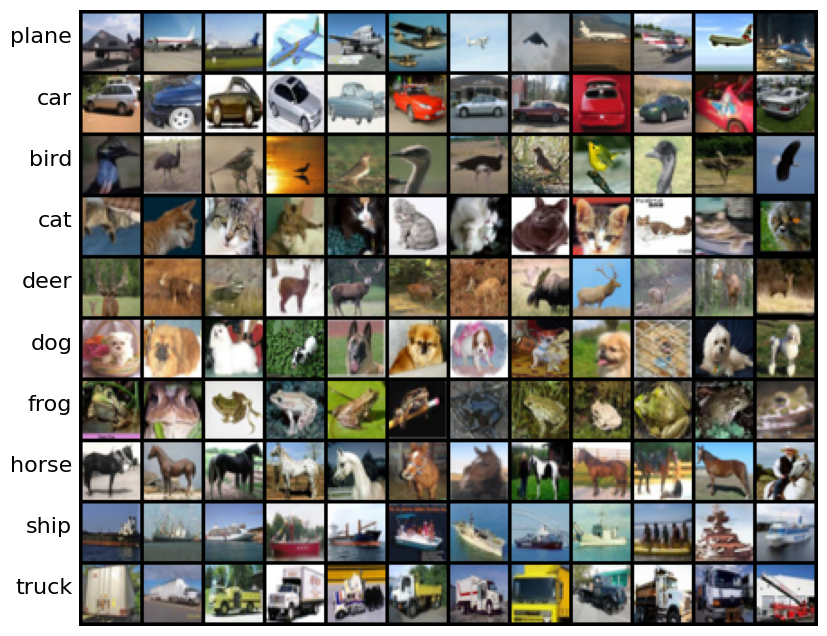

Train data shape: torch.Size([40000, 3073])
Train labels shape: torch.Size([40000])
Validation data shape: torch.Size([10000, 3073])
Validation labels shape: torch.Size([10000])
Test data shape: torch.Size([10000, 3073])
Test labels shape: torch.Size([10000])


In [9]:
# Invoke the above function to get our data.
reset_seed(0)

data_dict = common.data.preprocess_cifar10(bias_trick=True, cuda=True, dtype=torch.float64)
print('Train data shape:', data_dict['X_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['X_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['X_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

# SVM Classifier

In this section, you will:

- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In this assignment, your implementation should be independent to the device, i.e., you SHOULD NOT use `.to()` or `.cuda()` in each implementation block. Otherwise, your implementation would return an error when grading.

Recall that the SVM loss for the $i$-th data can be written as
$$
L_i = \sum_{j\neq y_i} \max(0, w_j^\top x_i - w_{y_i}^\top x_i + \Delta),
$$
where we set $\Delta = 1$ throughout this assignment.

If we define $m_{ij} \triangleq w_j^\top x_i - w_{y_i}^\top x_i + \Delta$ for brevity,
the derivative w.r.t. $w_j$ is
$$
\frac{\partial L_i}{\partial w_j} =
\begin{cases}
\mathbb{I}(m_{ij} > 0) x_i &\text{ if } j \neq y_i, \\
- \sum_{j\neq y_i} \mathbb{I}(m_{ij} > 0) x_i &\text{ if } j = y_i,
\end{cases}
$$
where $\mathbb{I}$ is the indicator function that returns 1 if the argument is true, and 0 otherwise.

First, we will test the naive version of svm loss in `linear_classifier.py`.
Let's first try the naive implementation of the loss we provided for you.
You will get the loss around `9.0`.
(Note: we've provided the loss part of the `svm_loss_naive` function, so you don't need to re-implement in `svm_loss_naive`.)

In [10]:
from linear_classifier import svm_loss_naive

reset_seed(0)
# generate a random SVM weight tensor of small numbers
W = torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device) * 0.0001

loss, _grad_ = svm_loss_naive(W, data_dict['X_val'], data_dict['y_val'], 0.000005)
print('loss: %f' % (loss, ))

loss: 9.000888


The `_grad_` returned from the function above is right now all zero.
**Implement** the gradient part in the `svm_loss_naive` function, by filing out the TODO blocks.
You will find it helpful to interweave your new code inside the existing function.

To check that you have implemented the gradient correctly, we will use **numeric gradient checking**:
we will use the finite difference approach to numerically estimate the gradient of the forward pass, and compare this numeric gradient to the analytic gradient that you implemented.

We have provided a function `common.grad.grad_check_sparse` to help with numeric gradient checking. You can learn more about this function using the `help` command:

In [11]:
help(common.grad.grad_check_sparse)

Help on function grad_check_sparse in module common.grad:

grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-07)
    Utility function to perform numeric gradient checking. We use the centered
    difference formula to compute a numeric derivative:
    
    f'(x) =~ (f(x + h) - f(x - h)) / (2h)
    
    Rather than computing a full numeric gradient, we sparsely sample a few
    dimensions along which to compute numeric derivatives.
    
    Inputs:
    - f: A function that inputs a torch tensor and returns a torch scalar
    - x: A torch tensor of the point at which to evaluate the numeric gradient
    - analytic_grad: A torch tensor giving the analytic gradient of f at x
    - num_checks: The number of dimensions along which to check
    - h: Step size for computing numeric derivatives



Now, run the following cell to perform numeric gradient checking on the gradients of your SVM loss.
You should see relative errors less than `1e-5`.

In [12]:
from linear_classifier import svm_loss_naive

# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Use a random W and a minibatch of data from the val set for gradient checking
# For numeric gradient checking it is a good idea to use 64-bit floating point
# numbers for increased numeric precision; however when actually training models
# we usually use 32-bit floating point numbers for increased speed.
reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
batch_size = 64
X_batch = data_dict['X_val'][:batch_size]
y_batch = data_dict['y_val'][:batch_size]

# Compute the loss and its gradient at W.
# Implement the gradient part of the 'svm_loss_naive' function
_, grad = svm_loss_naive(W, X_batch, y_batch, reg=0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_numerical = common.grad.grad_check_sparse(f, W, grad)

numerical:  0.031599 analytic:  0.031599, relative error: 3.139148e-07
numerical:  0.111444 analytic:  0.111444, relative error: 9.893848e-10
numerical:  0.011204 analytic:  0.011204, relative error: 1.003052e-06
numerical: -0.046128 analytic: -0.046128, relative error: 8.157190e-08
numerical:  0.071948 analytic:  0.071948, relative error: 1.000117e-07
numerical:  0.025688 analytic:  0.025688, relative error: 1.051337e-06
numerical:  0.185388 analytic:  0.185388, relative error: 7.039118e-09
numerical: -0.021740 analytic: -0.021740, relative error: 3.369463e-07
numerical: -0.159613 analytic: -0.159613, relative error: 6.416943e-08
numerical:  0.092690 analytic:  0.092690, relative error: 1.748534e-07


Let's do the gradient check once again with regularization turned on.

You should see relative errors less than `1e-5`.
If not, check if you didn't forget the regularization gradient.


In [13]:
from linear_classifier import svm_loss_naive

# Use a minibatch of data from the val set for gradient checking
reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
batch_size = 64
X_batch = data_dict['X_val'][:batch_size]
y_batch = data_dict['y_val'][:batch_size]

# Compute the loss and its gradient at W.
# Check your 'svm_loss_naive' implementation with different 'reg'
_, grad = svm_loss_naive(W, X_batch, y_batch, reg=1e3)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=1e3)[0]
grad_numerical = common.grad.grad_check_sparse(f, W, grad)

numerical:  0.124849 analytic:  0.124849, relative error: 6.251581e-08
numerical:  0.168915 analytic:  0.168915, relative error: 5.957873e-09
numerical:  0.148752 analytic:  0.148752, relative error: 8.733009e-08
numerical: -0.024936 analytic: -0.024936, relative error: 6.470254e-08
numerical: -0.008570 analytic: -0.008570, relative error: 7.174549e-07
numerical: -0.103155 analytic: -0.103155, relative error: 2.498757e-07
numerical: -0.335573 analytic: -0.335573, relative error: 4.472387e-09
numerical: -0.222176 analytic: -0.222176, relative error: 4.264915e-08
numerical:  0.681163 analytic:  0.681163, relative error: 1.235571e-08
numerical: -0.004090 analytic: -0.004089, relative error: 4.327973e-06


Now, **implement** the loss part of the `svm_loss_vectorized` function, which is the vectorized version of SVM.
It should compute the same inputs and outputs as the naive version before, but it should involve **no explicit loops**.

Then, check the performance speed difference between the non-vectorized and the vectorized version.
The difference between the gradients should be less than `1e-6`, and the vectorized version should run 15--120x faster.

PyTorch does some extra setup the first time you run CUDA code, so **you may need to run this cell more than once to see the desired speedup**.

In [15]:
from linear_classifier import svm_loss_naive, svm_loss_vectorized

# Use random weights and a minibatch of val data for gradient checking
reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss: %e computed in %.2fms' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
# Implement the loss part of the 'svm_loss_vectorized' function
loss_vec, _ = svm_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss: %e computed in %.2fms' % (loss_vec, ms_vec))

# The losses should match but your vectorized implementation should be much faster.
print('Difference: %.2e' % (loss_naive - loss_vec))
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss: 9.002394e+00 computed in 240.67ms
Vectorized loss: 9.002394e+00 computed in 1.47ms
Difference: -5.33e-15
Speedup: 163.26X


Now, **implement** the vectorized version of the gradient in the `svm_loss_vectorized` function.
Run the cell below to compare the gradient of your naive and vectorized implementations.
The difference between the gradients should be less than `1e-6`, and the vectorized version should run 15--120x faster.


In [16]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.

from linear_classifier import svm_loss_naive, svm_loss_vectorized

# Use random weights and a minibatch of val data for gradient checking
reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss and gradient: computed in %.2fms' % ms_naive)

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
# Implement the gradient part of the 'svm_loss_vectorized' function
_, grad_vec = svm_loss_vectorized(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss and gradient: computed in %.2fms' % ms_vec)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a tensor, so
# we use the Frobenius norm to compare them.
grad_difference = torch.norm(grad_naive - grad_vec, p='fro')
print('Gradient difference: %.2e' % grad_difference)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss and gradient: computed in 239.28ms
Vectorized loss and gradient: computed in 1.70ms
Gradient difference: 1.86e-14
Speedup: 141.04X


Now that we have an efficient vectorized implementation of the SVM loss and its gradient, we can implement a training pipeline for linear classifiers.

**Implement** `sample_batch` and `train_linear_classifier`. We are going to use `torch.randint` to sample a minibatch in `sample_batch`, and update the weights using stochastic gradient descent (SGD) in `train_linear_classifier`:

$$
w \leftarrow w - \alpha \nabla_w L.
$$

Once you have implemented the training function, run the following cell to train a linear classifier using some default hyperparameters.

You should see the final loss close to `9.0`, and your training loop should run in about two seconds.

In [17]:
from linear_classifier import svm_loss_vectorized, train_linear_classifier

# fix random seed before we perform this operation
reset_seed(0)

torch.cuda.synchronize()
tic = time.time()

# Implement 'sample_batch' and 'train_linear_classifier'
W, loss_hist = train_linear_classifier(svm_loss_vectorized, None,
                                       data_dict['X_train'],
                                       data_dict['y_train'],
                                       learning_rate=3e-11, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration    0 / 1500: loss 9.000785
iteration  100 / 1500: loss 9.000762
iteration  200 / 1500: loss 9.000777
iteration  300 / 1500: loss 9.000766
iteration  400 / 1500: loss 9.000778
iteration  500 / 1500: loss 9.000771
iteration  600 / 1500: loss 9.000772
iteration  700 / 1500: loss 9.000770
iteration  800 / 1500: loss 9.000772
iteration  900 / 1500: loss 9.000772
iteration 1000 / 1500: loss 9.000770
iteration 1100 / 1500: loss 9.000789
iteration 1200 / 1500: loss 9.000787
iteration 1300 / 1500: loss 9.000769
iteration 1400 / 1500: loss 9.000778
That took 1.432450s


A useful debugging strategy is to plot the loss as a function of iteration number.
In this case, it seems our hyperparameters are not good, since the training loss is not decreasing very fast.



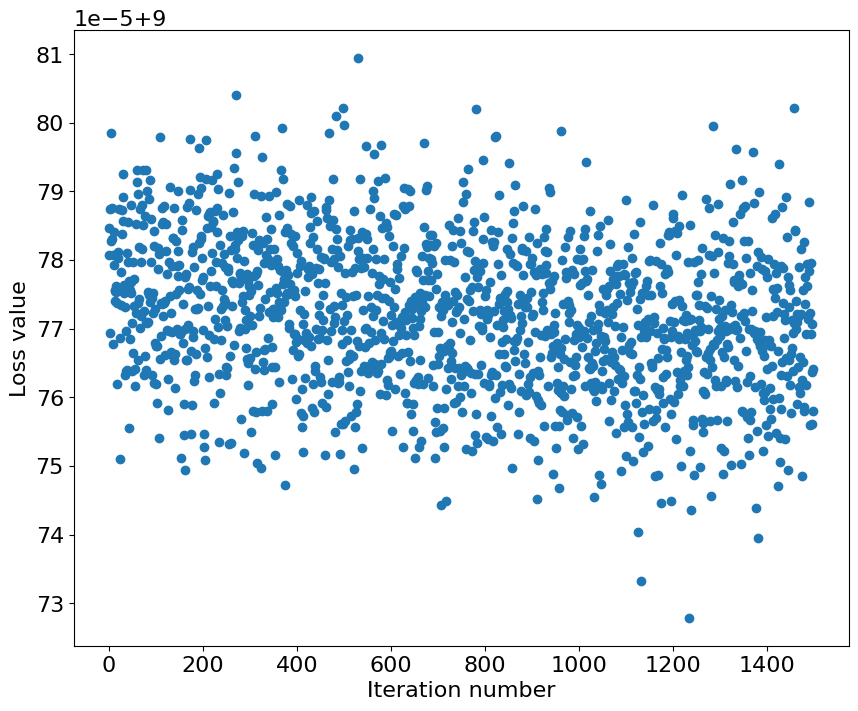

In [18]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Then, let's move on to the prediction stage.
We can evaluate the performance our trained model on both the training and validation set.
You should see validation accuracy less than 20%.

In [19]:
from linear_classifier import predict_linear_classifier

# fix random seed before we perform this operation
reset_seed(0)

# Implement 'predict_linear_classifier' and evaluate the performance on both
# training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).double().mean().item()
print('Training accuracy: %.2f%%' % train_acc)

y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).double().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

Training accuracy: 9.24%
Validation accuracy: 9.00%


Unfortunately, the performance of our initial model is quite bad. To find better hyperparameters, we first modulized the functions that we've implemented as LinearSVM.

Let's use the validation set to tune hyperparameters (regularization strength and learning rate);
**implement** `svm_get_search_params` and `test_one_param_set`.
You should experiment with different ranges for the learning rates and regularization strengths.

To get full credit for the assignment, your best model found through validation should achieve the accuracy above 37% on the validation set.

(Our best model got around 38.1% -- did you beat us?)

In [20]:
from linear_classifier import LinearSVM, svm_get_search_params, test_one_param_set

# Find the best learning_rates and regularization_strengths combination in
# 'svm_get_search_params'
learning_rates, regularization_strengths = svm_get_search_params()
num_models = len(learning_rates) * len(regularization_strengths)

####
# It is okay to comment out the following conditions when you are working on svm_get_search_params.
# But, please do not forget to reset back to the original setting once you are done.
if num_models > 25:
  raise Exception("Please do not test/submit more than 25 items at once")
elif num_models < 5:
  raise Exception("Please present at least 5 parameter sets in your final ipynb")
####


i = 0
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (train_acc, val_acc).
results = {}
best_val = -1.0   # The highest validation accuracy that we have seen so far.
best_svm_model = None # The LinearSVM object that achieved the highest validation rate.
num_iters = 2000 # number of iterations

for lr in learning_rates:
    for reg in regularization_strengths:
        i += 1
        print('Training SVM %d / %d with learning_rate=%e and reg=%e'
              % (i, num_models, lr, reg))

        reset_seed(0)
        # Implement a function that gives the trained model with train/validation
        # accuracies in 'test_one_param_set'
        # (note: this function will be used in Softmax Classifier section as well)
        cand_svm_model, cand_train_acc, cand_val_acc = test_one_param_set(LinearSVM(), data_dict, lr, reg, num_iters)

        if cand_val_acc > best_val:
            best_val = cand_val_acc
            best_svm_model = cand_svm_model # save the svm
        results[(lr, reg)] = (cand_train_acc, cand_val_acc)


# Print out results.
for lr, reg in sorted(results):
    train_acc, val_acc = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f'
          % (lr, reg, train_acc, val_acc))

print('best validation accuracy achieved during validation: %f' % best_val)

# save the best model
path = os.path.join(GOOGLE_DRIVE_PATH, 'svm_best_model.pt')
best_svm_model.save(path)

Training SVM 1 / 12 with learning_rate=1.000000e-03 and reg=1.000000e+00
Training SVM 2 / 12 with learning_rate=1.000000e-03 and reg=1.000000e+01
Training SVM 3 / 12 with learning_rate=1.000000e-03 and reg=1.000000e-01
Training SVM 4 / 12 with learning_rate=1.000000e-03 and reg=3.000000e-01
Training SVM 5 / 12 with learning_rate=1.000000e-02 and reg=1.000000e+00
Training SVM 6 / 12 with learning_rate=1.000000e-02 and reg=1.000000e+01
Training SVM 7 / 12 with learning_rate=1.000000e-02 and reg=1.000000e-01
Training SVM 8 / 12 with learning_rate=1.000000e-02 and reg=3.000000e-01
Training SVM 9 / 12 with learning_rate=1.000000e-01 and reg=1.000000e+00
Training SVM 10 / 12 with learning_rate=1.000000e-01 and reg=1.000000e+01
Training SVM 11 / 12 with learning_rate=1.000000e-01 and reg=1.000000e-01
Training SVM 12 / 12 with learning_rate=1.000000e-01 and reg=3.000000e-01
lr 1.000000e-03 reg 1.000000e-01 train accuracy: 38.687500 val accuracy: 37.349999
lr 1.000000e-03 reg 3.000000e-01 train

Visualize the validation results.
You can use this as a debugging tool -- after examining the validation results here, you may want to go back and rerun your validation from above.

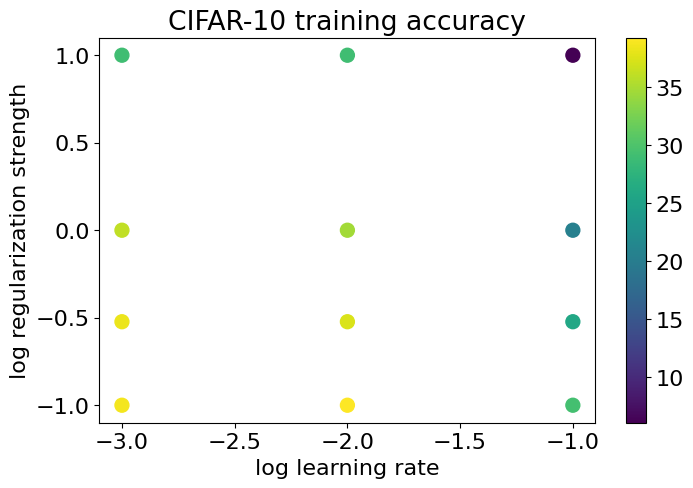

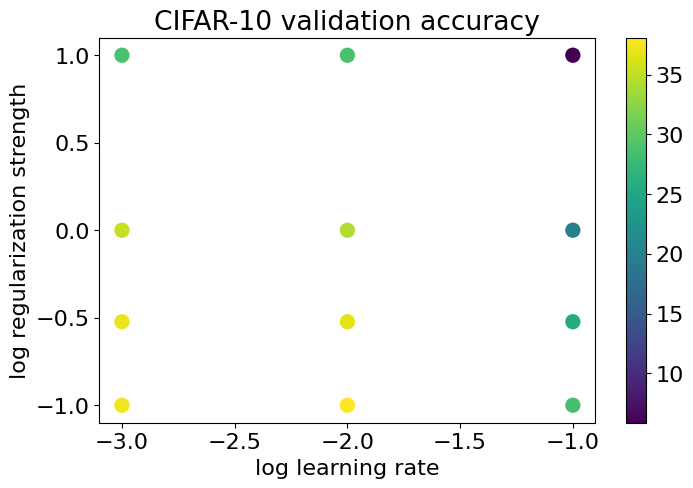

In [21]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Then, evaluate the performance of your best model on the test set.
To get full credit for the assignment, your model should achieve the test set accuracy above 36%.

(Our best got around 39.2% -- did you beat us?)

In [22]:
reset_seed(0)

y_test_pred = best_svm_model.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).double())
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.381500


Finally, visualize the learned weights for each class.
Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at.

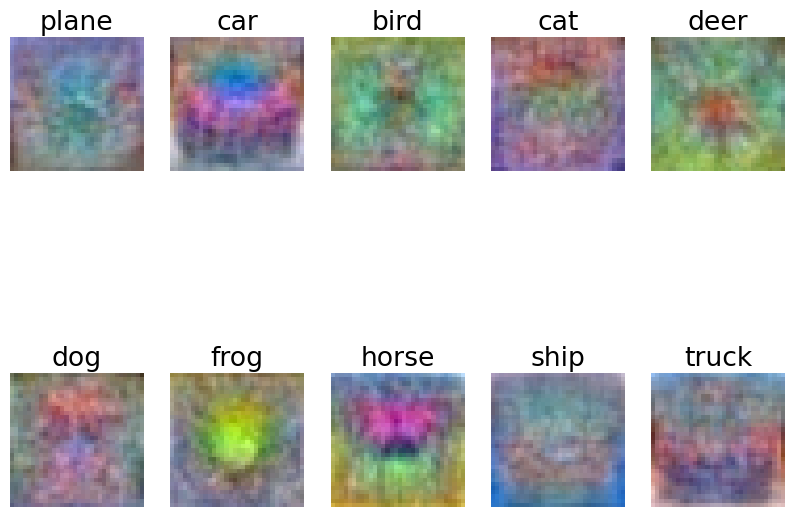

In [23]:
w = best_svm_model.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.type(torch.uint8).cpu())
    plt.axis('off')
    plt.title(classes[i])

# Softmax Classifier

Similar to the SVM, you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

As noted in the SVM section, you SHOULD NOT use `.to()` or `.cuda()` in each implementation block.

With the **bias trick**, recall that the Softmax loss for the $i$-th data can be written as
$$
L_i = -\log p_{y_i} = -\log \frac{\exp(w_{y_i}^\top x_i)}{\sum_j \exp(w_j^\top x_i)} = -w_{y_i}^\top x_i + \log \sum_j \exp(w_j^\top x_i).
$$

The derivative w.r.t. $w_j$ is
$$
\frac{\partial L_i}{\partial w_j} = \left( p_{j} - \mathbb{I}(j = y_i) \right) x_i,
$$
where $\mathbb{I}$ is the indicator function that returns 1 if the argument is true, and 0 otherwise.

**Practical issues: numeric stability**

When you are writing code for computing the Softmax function in practice, the intermediate terms $\exp(w_{y_i}^\top x_i)$ and $\sum_j \exp(w_j^\top x_i)$ may be very large due to the exponentials.
Dividing large numbers can be numerically unstable, so it is important to use a normalization trick.
Note that if we multiply the top and bottom of the fraction by a constant $C$ and push it into the sum, we get the following (mathematically equivalent) expression:
$$
L_i = -\log p_{y_i} = -\log \frac{\exp(w_{y_i}^\top x_i + C)}{\sum_j \exp(w_j^\top x_i + C)} = -(w_{y_i}^\top x_i + C) + \log \sum_j \exp(w_j^\top x_i  + C).
$$
Here, we are free to choose the value of $C$, but the common choice is $C = - \max_j w_j^\top x_i$ to ensure that the largest value of $w_j^\top x_i$ is zero.

**Note that this is the Softmax *loss* you will actually implement.**

First, let's start from the naive softmax loss function with nested loops.
**Implement** the loss and gradients in the `softmax_loss_naive` function.

As a sanity check to see whether we have implemented the loss correctly, run the softmax classifier with a small random weight matrix and no regularization. You should see the loss near `log(10) = 2.3`.

In [24]:
from linear_classifier import softmax_loss_naive

reset_seed(0)
# Generate a random softmax weight tensor and use it to compute the loss.
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Complete the implementation of the 'softmax_loss_naive' function and
# implement a (naive) version of the gradient that uses nested loops.
loss, _ = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

# As a rough sanity check, our loss should be something close to log(10.0).
print('loss: %f' % loss)
print('sanity check: %f' % (math.log(10.0)))

loss: 2.302826
sanity check: 2.302585


Next, we use gradient checking to debug the analytic gradient of the `softmax_loss_naive` function.
If you've implemented the gradient correctly, you should see relative errors less than `1e-5`.


In [25]:
from linear_classifier import softmax_loss_naive

reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Complete the implementation of the 'softmax_loss_naive' function and
# implement a (naive) version of the gradient that uses nested loops.
_, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
common.grad.grad_check_sparse(f, W, grad, 10)

numerical:  0.003046 analytic:  0.003046, relative error: 6.468497e-07
numerical:  0.006308 analytic:  0.006308, relative error: 1.234992e-07
numerical:  0.005392 analytic:  0.005392, relative error: 2.534459e-07
numerical:  0.002581 analytic:  0.002581, relative error: 3.442300e-08
numerical:  0.007512 analytic:  0.007512, relative error: 8.122736e-07
numerical:  0.006417 analytic:  0.006417, relative error: 1.501422e-07
numerical:  0.011391 analytic:  0.011391, relative error: 1.960823e-07
numerical:  0.001822 analytic:  0.001822, relative error: 2.932218e-06
numerical: -0.014710 analytic: -0.014710, relative error: 8.967622e-08
numerical: -0.005153 analytic: -0.005153, relative error: 4.012889e-07


Let's perform another gradient check with regularization enabled.
Again, you should see relative errors less than `1e-5`.

In [26]:
from linear_classifier import softmax_loss_naive

reset_seed(1)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 10.0

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Complete the gradient part of the 'softmax_loss_naive' function
_, grad = softmax_loss_naive(W, X_batch, y_batch, reg)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg)[0]
common.grad.grad_check_sparse(f, W, grad, 10)

numerical:  0.001012 analytic:  0.001012, relative error: 1.869441e-06
numerical:  0.006688 analytic:  0.006688, relative error: 2.903702e-07
numerical:  0.008150 analytic:  0.008150, relative error: 2.046311e-07
numerical:  0.006395 analytic:  0.006395, relative error: 1.125666e-07
numerical:  0.003987 analytic:  0.003987, relative error: 4.635333e-07
numerical:  0.005783 analytic:  0.005783, relative error: 2.494830e-07
numerical:  0.008091 analytic:  0.008090, relative error: 5.337923e-07
numerical: -0.001412 analytic: -0.001412, relative error: 1.105811e-06
numerical: -0.016983 analytic: -0.016983, relative error: 9.906163e-08
numerical: -0.003150 analytic: -0.003150, relative error: 5.395270e-07


Then, let's move on to the vectorized form.
**Implement** the `softmax_loss_vectorized` function.
The two versions should compute the same results, but the vectorized version should be much faster.

The differences between the naive and vectorized losses and gradients should be less than `1e-6`, and your vectorized implementation should be at least 20x faster than the naive implementation.

In [29]:
from linear_classifier import softmax_loss_naive, softmax_loss_vectorized

reset_seed(0)
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 0.05

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

# Run and time the vectorized version
# Implement the 'softmax_loss_vectorized' function
torch.cuda.synchronize()
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vec, ms_vec))

# we use the Frobenius norm to compare the two versions of the gradient.
loss_diff = (loss_naive - loss_vec).abs().item()
grad_diff = torch.norm(grad_naive - grad_vec, p='fro')
print('Loss difference: %.2e' % loss_diff)
print('Gradient difference: %.2e' % grad_diff)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

naive loss: 2.302841e+00 computed in 133.558989s
vectorized loss: 2.298659e+00 computed in 95.907927s
Loss difference: 4.18e-03
Gradient difference: 7.54e-16
Speedup: 1.39X


Let's check that your implementation of the softmax loss is numerically stable.

If either of the following print `nan` rather than a very large number, then you should double-check the numeric stability of your implementation.

In [30]:
from linear_classifier import softmax_loss_naive, softmax_loss_vectorized

reset_seed(0)
device = data_dict['X_train'].device
dtype = data_dict['X_train'].dtype
D = data_dict['X_train'].shape[1]
C = 10

# You've implemented 'train_linear_classifier' in the SVM section
W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_naive, W_ones,
                                       data_dict['X_train'],
                                       data_dict['y_train'],
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_ones,
                                       data_dict['X_train'],
                                       data_dict['y_train'],
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


iteration    0 /    1: loss nan
iteration    0 /    1: loss nan


Now, let's train a softmax classifier with some default hyperparameters:


In [31]:
from linear_classifier import softmax_loss_vectorized

reset_seed(0)

torch.cuda.synchronize()
tic = time.time()

# You've implemented 'train_linear_classifier' in the SVM section
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None,
                                       data_dict['X_train'],
                                       data_dict['y_train'],
                                       learning_rate=1e-10, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration    0 / 1500: loss 2.303367
iteration  100 / 1500: loss 2.303351
iteration  200 / 1500: loss 2.303320
iteration  300 / 1500: loss 2.303304
iteration  400 / 1500: loss 2.303333
iteration  500 / 1500: loss 2.303389
iteration  600 / 1500: loss 2.303345
iteration  700 / 1500: loss 2.303355
iteration  800 / 1500: loss 2.303373
iteration  900 / 1500: loss 2.303338
iteration 1000 / 1500: loss 2.303350
iteration 1100 / 1500: loss 2.303348
iteration 1200 / 1500: loss 2.303296
iteration 1300 / 1500: loss 2.303341
iteration 1400 / 1500: loss 2.303345
That took 217.885192s


Plot the loss curve:

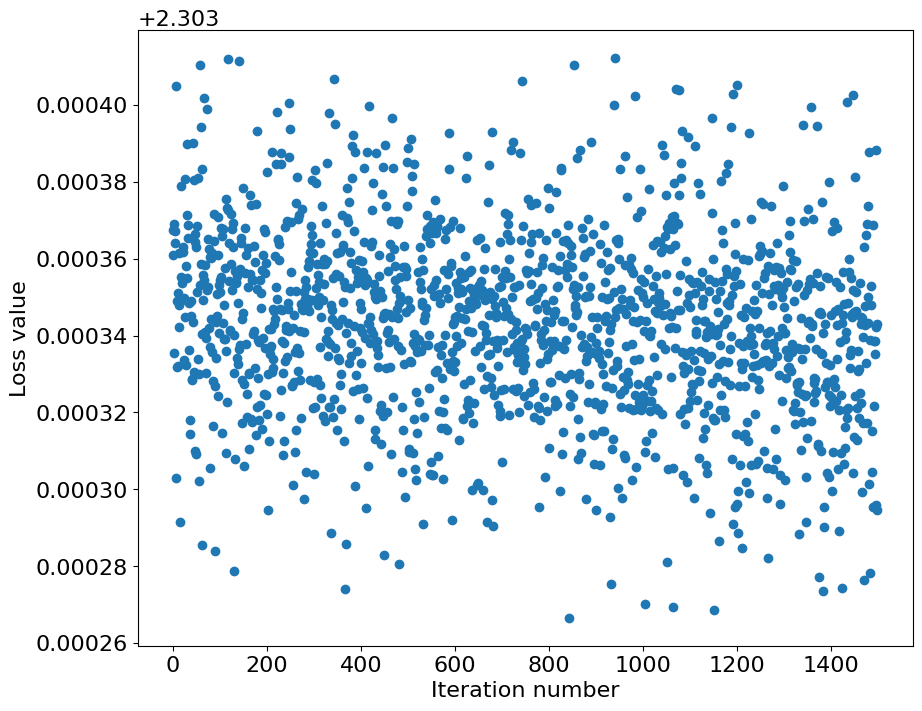

In [32]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let's compute the accuracy of current model. It should be less than 10%.

In [33]:
from linear_classifier import predict_linear_classifier

reset_seed(0)

# evaluate the performance on both the training and validation set
# You've implemented 'predict_linear_classifier' in the SVM section
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).double().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).double().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

training accuracy: 8.90%
validation accuracy: 8.54%


Again, let's use the validation set to tune hyperparameters (regularization strength and learning rate);
**implement** `softmax_get_search_params`.
You should experiment with different ranges for the learning rates and regularization strengths.

To get full credit for the assignment, your best model found through validation should achieve the accuracy above 37% on the validation set.

(Our best model got around 39.8% -- did you beat us?)

In [13]:
from linear_classifier import Softmax, softmax_get_search_params, test_one_param_set

# Find the best learning_rates and regularization_strengths combination in
# 'softmax_get_search_params'
learning_rates, regularization_strengths = softmax_get_search_params()
num_models = len(learning_rates) * len(regularization_strengths)

####
# It is okay to comment out the following conditions when you are working on svm_get_search_params.
# But, please do not forget to reset back to the original setting once you are done.
if num_models > 25:
  raise Exception("Please do not test/submit more than 25 items at once")
elif num_models < 5:
  raise Exception("Please present at least 5 parameter sets in your final ipynb")
####


i = 0
# As before, store your validation results in this dictionary.
# The keys should be tuples of (learning_rate, regularization_strength) and
# the values should be tuples (train_acc, val_acc)
results = {}
best_val = -1.0   # The highest validation accuracy that we have seen so far.
best_softmax_model = None # The Softmax object that achieved the highest validation rate.
num_iters = 2000 # number of iterations

for lr in learning_rates:
    for reg in regularization_strengths:
        i += 1
        print('Training Softmax %d / %d with learning_rate=%e and reg=%e'
              % (i, num_models, lr, reg))

        reset_seed(0)
        cand_softmax_model, cand_train_acc, cand_val_acc = test_one_param_set(Softmax(), data_dict, lr, reg, num_iters)

        if cand_val_acc > best_val:
            best_val = cand_val_acc
            best_softmax_model = cand_softmax_model # save the classifier
        results[(lr, reg)] = (cand_train_acc, cand_val_acc)


# Print out results.
for lr, reg in sorted(results):
    train_acc, val_acc = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f'
          % (lr, reg, train_acc, val_acc))

print('best validation accuracy achieved during validation: %f' % best_val)

# save the best model
path = os.path.join(GOOGLE_DRIVE_PATH, 'softmax_best_model.pt')
best_softmax_model.save(path)

Training Softmax 1 / 6 with learning_rate=1.000000e-02 and reg=1.000000e-01
Training Softmax 2 / 6 with learning_rate=1.000000e-02 and reg=1.000000e-02
Training Softmax 3 / 6 with learning_rate=1.000000e-02 and reg=1.000000e-01
Training Softmax 4 / 6 with learning_rate=1.000000e-02 and reg=1.000000e-02
Training Softmax 5 / 6 with learning_rate=1.000000e-01 and reg=1.000000e-01
Training Softmax 6 / 6 with learning_rate=1.000000e-01 and reg=1.000000e-02
lr 1.000000e-02 reg 1.000000e-02 train accuracy: 40.364999 val accuracy: 38.549998
lr 1.000000e-02 reg 1.000000e-01 train accuracy: 36.945000 val accuracy: 35.979998
lr 1.000000e-01 reg 1.000000e-02 train accuracy: 41.004997 val accuracy: 39.069998
lr 1.000000e-01 reg 1.000000e-01 train accuracy: 36.182499 val accuracy: 35.349998
best validation accuracy achieved during validation: 39.069998
Saved in /content/drive/MyDrive/STA9131/A2/softmax_best_model.pt


Run the following to visualize your validation results:

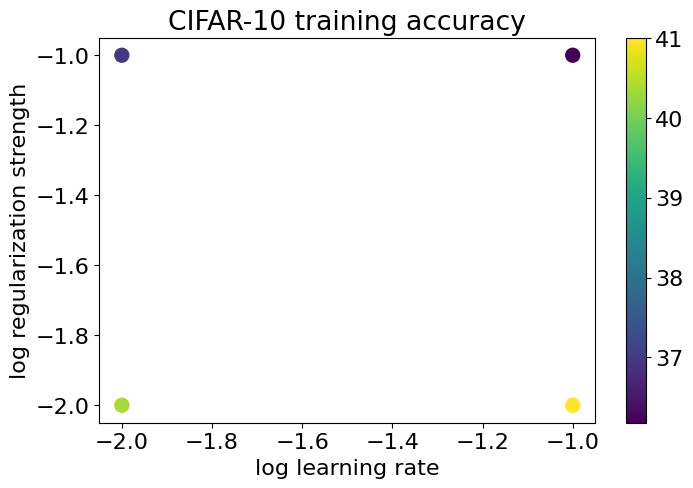

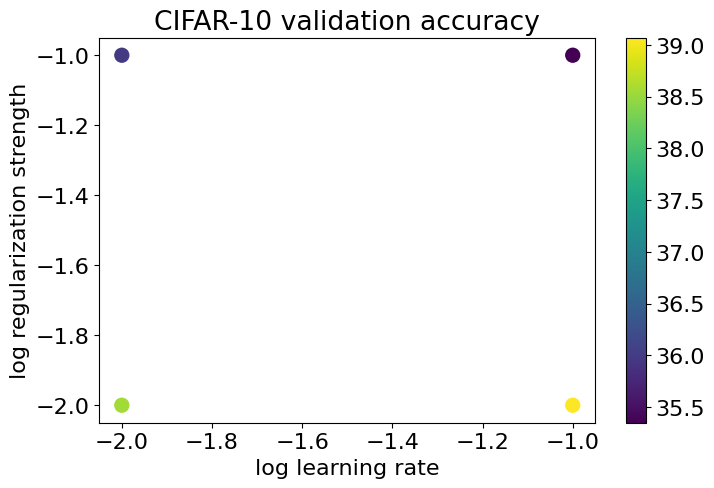

In [14]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Then, evaluate the performance of your best model on the test set. To get full credit for the assignment, your model should achieve the test set accuracy above 36%.

(Our best model got around 39.9% -- did you beat us?)

In [15]:
y_test_pred = best_softmax_model.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).double())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.396300


Finally, visualize the learned weights for each class.
Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at.

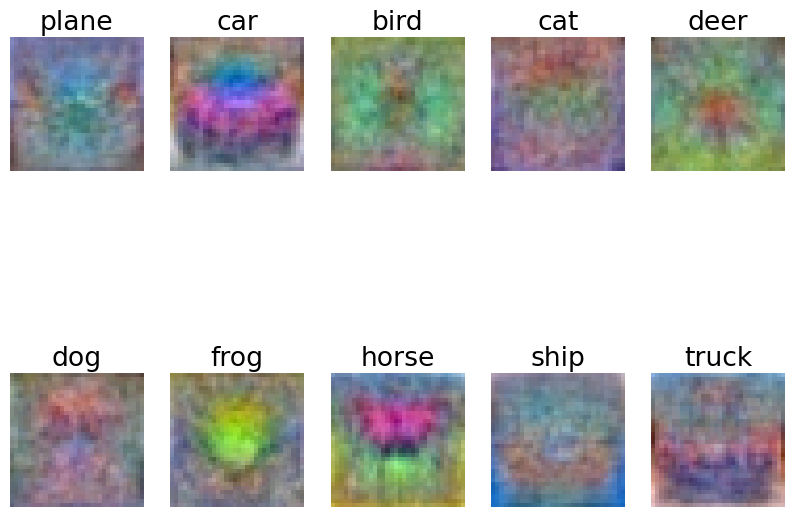

In [16]:
w = best_softmax_model.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.type(torch.uint8).cpu())
    plt.axis('off')
    plt.title(classes[i])

# Final Check
Done! Before you move, please check if all outputs are displayed properly and the outputs are same as what you expected.
Also, please check if you generated any additional cells and/or modified existing cells; you should not change them unless otherwise instructed with `TODO`.

Your change may not always be automatically saved, so **please MANUALLY SAVE every `*.ipynb` and `*.py` files.**